In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import cycle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Input
from tensorflow import keras

# Set seed for reproducibility
seed = 101
np.random.seed(seed)

In [ ]:
# Load and preprocess data
df = pd.read_csv('/content/bitcointweets_with_1000_more_negative.csv', header=None)
df = df[[1, 7]]
df.columns = ['TweetContent', 'Sentiment']
df['text_length'] = df['TweetContent'].astype(str).apply(len)

def clean_text(s):
    s = str(s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\b\W*@\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

df['clean_tweet'] = df['TweetContent'].apply(clean_text)
X = df['clean_tweet']
y = pd.get_dummies(df['Sentiment']).values
num_classes = df['Sentiment'].nunique()

# Tokenize text
max_features = 20000
max_words = 30
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(list(X))
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_words)

# Stratified Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
train_index, test_index = next(skf.split(X, np.argmax(y, axis=1)))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]


NameError: name 'pd' is not defined

In [ ]:
def get_model(max_features, embed_dim):
    K.clear_session()
    input_layer = Input(shape=(X_train.shape[1],))
    embedding_layer = Embedding(max_features, embed_dim, input_length=X_train.shape[1])(input_layer)
    conv1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    bilstm = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(pool2)
    global_avg_pool = keras.layers.GlobalAveragePooling1D()(bilstm)
    output_layer = Dense(num_classes, activation='softmax')(global_avg_pool)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


In [ ]:
def model_train(model):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=8, batch_size=32, verbose=2)
    return history


In [ ]:
# Plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, num_classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall Curve
def plot_precision_recall(y_test, y_pred_prob, num_classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
        ap = average_precision_score(y_test[:, i], y_pred_prob[:, i])
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'Class {i} (AP = {ap:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()

# Plot Confusion Matrix Heatmap
def plot_confusion_matrix_heatmap(confmat, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confmat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Plot Learning Curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


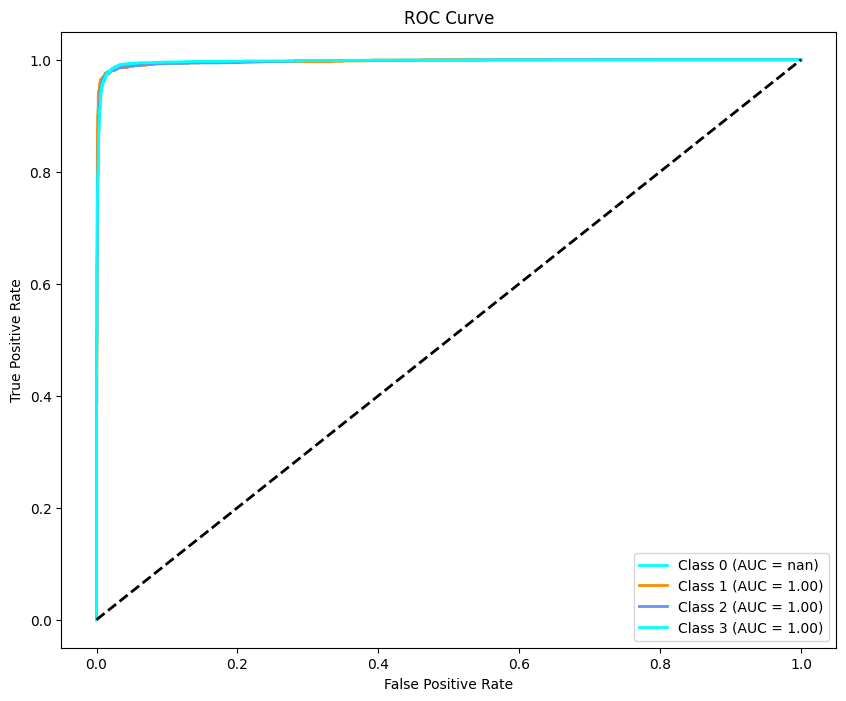

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


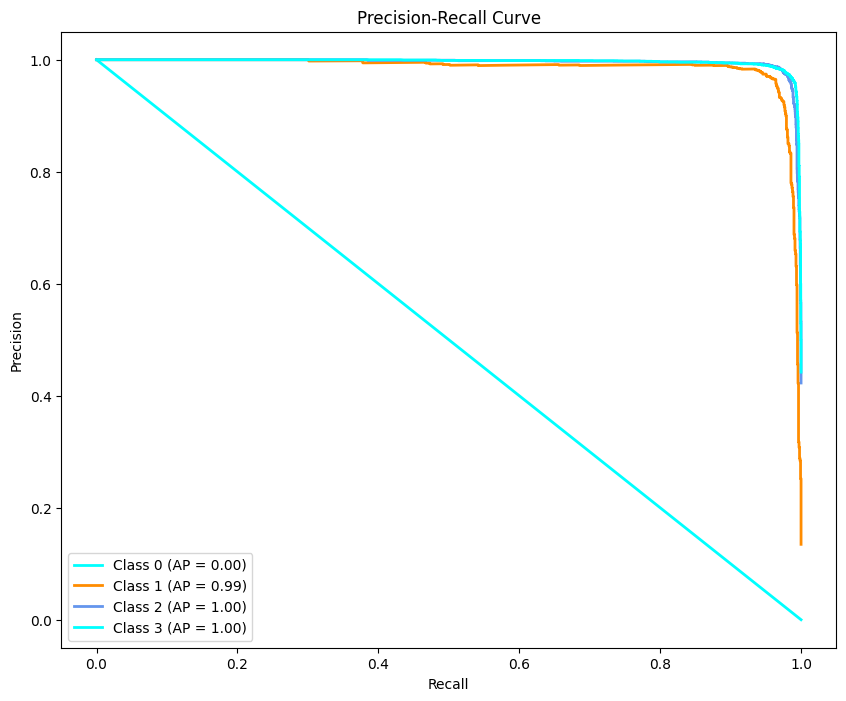

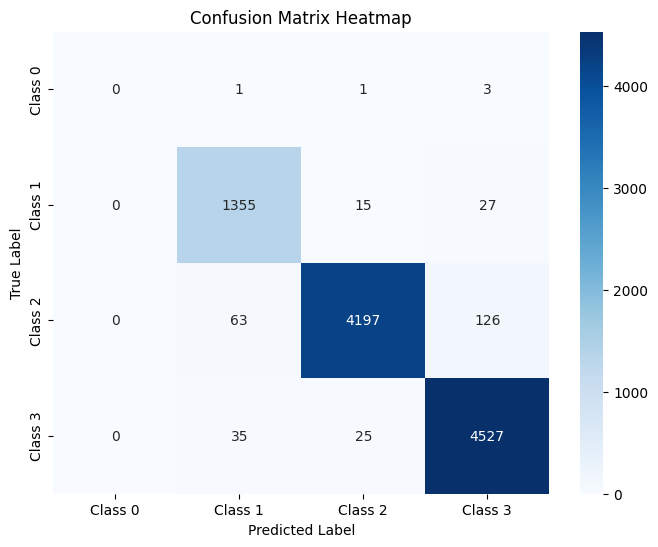

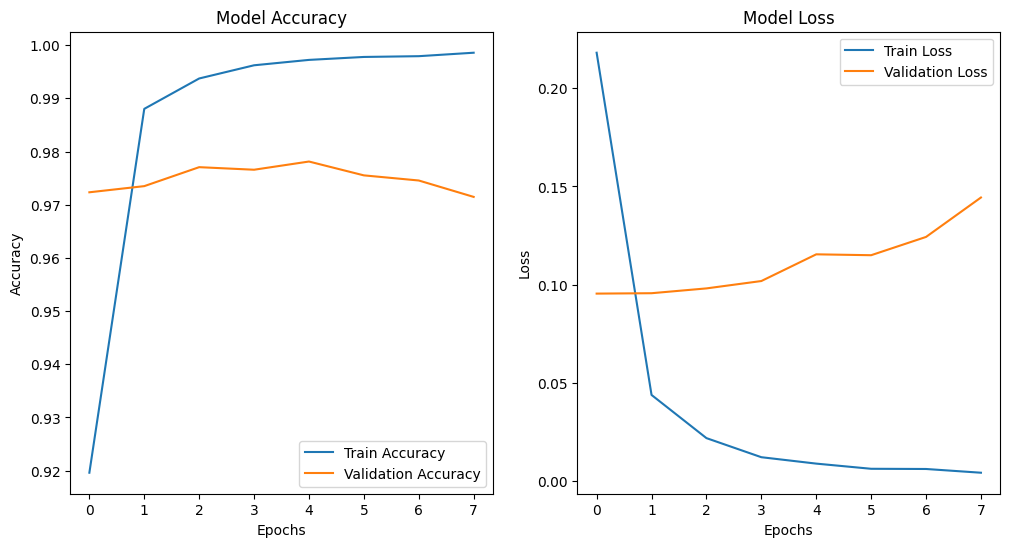

In [ ]:
embed_dim = 100
model = get_model(max_features, embed_dim)
history = model_train(model)

# Generate predictions
y_pred_prob = model.predict(X_test)

# ROC Curve
plot_roc_curve(y_test, y_pred_prob, num_classes)

# Precision-Recall Curve
plot_precision_recall(y_test, y_pred_prob, num_classes)

# Confusion Matrix
y_pred_test = np.argmax(y_pred_prob, axis=1)
confmat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
class_names = [f"Class {i}" for i in range(num_classes)]
plot_confusion_matrix_heatmap(confmat, class_names)

# Learning Curve
plot_learning_curve(history)


In [ ]:
# Plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, num_classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    roc_auc_scores = []  # Store AUC scores for each class
    for i, color in zip(range(num_classes), colors):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)  # Append AUC score
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    # Calculate and print overall accuracy (average AUC)
    overall_accuracy = np.mean(roc_auc_scores)
    print(f"Overall Accuracy (Average AUC): {overall_accuracy:.2f}")

    plt.show()